In [ ]:
# # Google Colab Specific commands
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Example: Unzip into the current working directory - since i have a zip in my drive and i want to unzip into my colab env for faster access
!unzip -q "/content/drive/MyDrive/Colab Notebooks/pravin_thesis/0_dataset/11_balanced_class_subfolder_no_label.zip" -d '/content/dataset/'

In [ ]:
!pip install keras_cv rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 65.8 MB/s eta 0:00:00


In [ ]:
# Standard Library Imports
import os
import random
import shutil
import warnings
# Data Analysis and Manipulation
import pandas as pd
import numpy as np
# Image Processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import rasterio
from PIL import Image
import PIL
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
# Machine Learning and Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import AdamW
import keras_cv
keras.mixed_precision.set_global_policy("mixed_float16")
# Progress Bars
import tqdm
from tqdm.auto import trange, tqdm
# Evaluation Metrics
import sklearn
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend


In [ ]:
IMAGE_SIZE = (224,224) #For MobileNetV3Large
BATCH_SIZE = 32
COLOR_MODE = "rgb"
SHUFFLE = True
TRAIN_PATH = "/content/dataset/"
SEED = 4224
AUTOTUNE = tf.data.experimental.AUTOTUNE
NUM_CLASSES = 4
NUM_EPOCHS = 50
INITIAL_LEARNING_RATE = 0.0001

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
# Function to split data
def split_data(path, seed, test_size=0.1, val_size=0.2):
    all_files = []
    all_labels = []

    # Iterate through directory and collect file paths and labels
    for class_dir in os.listdir(path):
        class_path = os.path.join(path, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                img_path = os.path.join(class_path, img)
                all_files.append(img_path)
                all_labels.append(class_dir)

    # Convert labels to numeric format
    label_to_index = {label: index for index, label in enumerate(np.unique(all_labels))}
    all_labels = [label_to_index[label] for label in all_labels]

    # Split into train+val and test
    train_val_files, test_files, train_val_labels, test_labels = train_test_split(
        all_files, all_labels, test_size=test_size, random_state=seed, stratify=all_labels
    )

    # Split train+val into train and validation sets
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_val_files, train_val_labels, test_size=val_size, random_state=seed, stratify=train_val_labels
    )

    return (train_files, train_labels), (val_files, val_labels), (test_files, test_labels)

# Helper function to create datasets from file paths and labels
def create_dataset(files, labels, imgsz, bsz, clr, shuffle, seed):
    dataset = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(files), seed=seed)
    dataset = dataset.map(lambda x, y: (load_image(x, imgsz, clr), y), num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(bsz).prefetch(buffer_size=AUTOTUNE)
    return dataset

# Load image utility function
def load_image(file_path, imgsz, clr):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3 if clr == "rgb" else 1)
    image = tf.image.resize(image, imgsz)
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Load and split the data
(train_files, train_labels), (val_files, val_labels), (test_files, test_labels) = split_data(TRAIN_PATH, SEED)

# Create datasets
train_batch = create_dataset(train_files, train_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, SHUFFLE, SEED)
val_batch = create_dataset(val_files, val_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, False, SEED)
test_batch = create_dataset(test_files, test_labels, IMAGE_SIZE, BATCH_SIZE, COLOR_MODE, False, SEED)


In [ ]:
def augment_img(img_, lbl_):
    image = tf.image.random_flip_left_right(img_)
    image = tf.image.central_crop(image, 0.85)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.5, 2.0)
    return tf.cast(image, tf.float32), lbl_

train_batch = train_batch.map(augment_img, tf.data.AUTOTUNE)
train_batch = train_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_batch = val_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_batch = test_batch.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
train_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(val_batch) * BATCH_SIZE

2048

Coccidiosis Percentage: 25.00%
Healthy Percentage: 25.00%
Newcastle Disease Percentage: 25.00%
Salmo Percentage: 25.00%


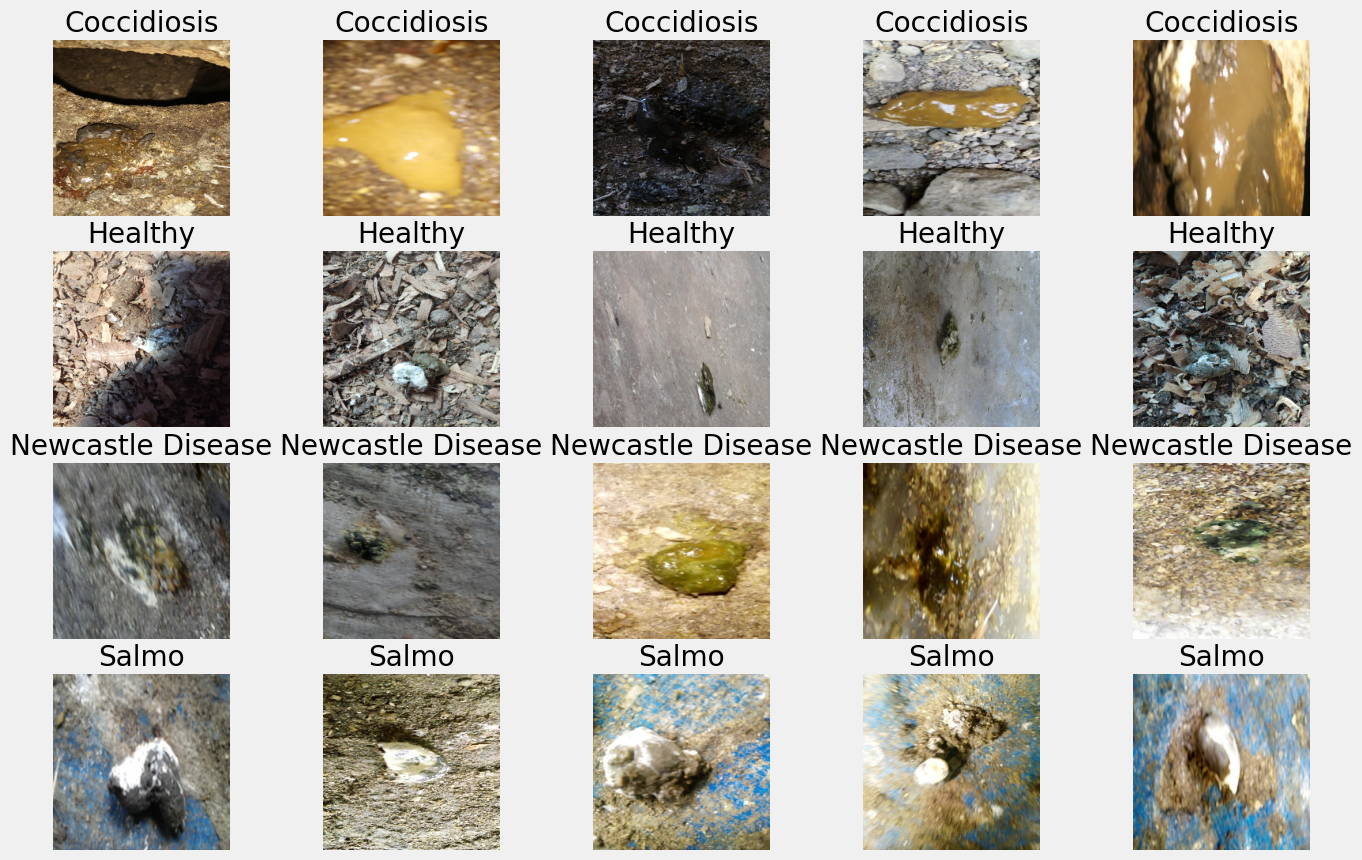

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def val_batch_class_distribution(valid_batch):
    images = []
    labels = []

    for img, lbl in valid_batch.unbatch():
        images.append(img.numpy())
        if lbl == 0:
            labels.append("Coccidiosis")
        elif lbl == 1:
            labels.append("Healthy")
        elif lbl == 2:
            labels.append("Newcastle Disease")
        else:
            labels.append("Salmo")

    images = np.array(images)
    labels = np.array(labels)

    coccidiosis_pct = np.mean(labels == "Coccidiosis")
    healthy_pct = np.mean(labels == "Healthy")
    newcastle_pct = np.mean(labels == "Newcastle Disease")
    salmo_pct = np.mean(labels == "Salmo")

    print(f'Coccidiosis Percentage: {coccidiosis_pct * 100:.2f}%')
    print(f'Healthy Percentage: {healthy_pct * 100:.2f}%')
    print(f'Newcastle Disease Percentage: {newcastle_pct * 100:.2f}%')
    print(f'Salmo Percentage: {salmo_pct * 100:.2f}%')

    return images, labels

def visualize_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_images = images[labels == class_name][:num_images]
        for j, img in enumerate(class_images):
            plt.subplot(len(class_names), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Get images and labels from the validation batch
images, labels = val_batch_class_distribution(val_batch)

# Define class names
class_names = ["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"]

# Visualize images
visualize_images(images, labels, class_names)


In [ ]:
def create_mobilenet_model():
  # LINK: https://keras.io/api/keras_cv/models/backbones/mobilenet_v3/
  # https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large
    backbone = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
    load_weights=True,
    # the suitable input shape: recommended 224x224
    input_shape = (224,224,3),
    include_rescaling = False)

    model = keras_cv.models.ImageClassifier(
        num_classes = NUM_CLASSES,
        pooling = "max",
        activation = "softmax",
        backbone = backbone,
        name = "MobileNet")
    model.trainable = True

    initial_learning_rate = INITIAL_LEARNING_RATE
    optimizer = keras.optimizers.AdamW(learning_rate = initial_learning_rate)

    model.compile(optimizer = optimizer,
                  loss = keras.losses.SparseCategoricalCrossentropy(),
                  metrics = ["accuracy"])
    return model


In [ ]:
mobilenet_model = create_mobilenet_model()

100%|██████████| 2.24k/2.24k [00:00<00:00, 2.26MB/s]


100%|██████████| 11.9M/11.9M [00:02<00:00, 5.42MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


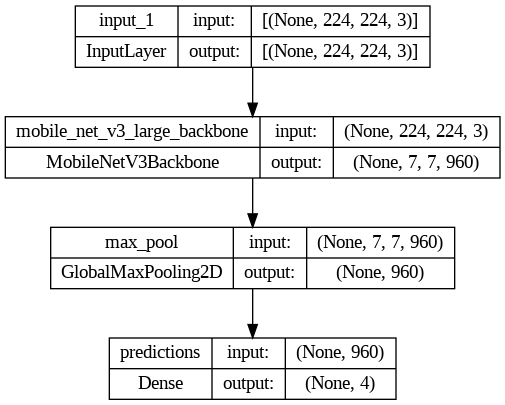

In [ ]:
keras.utils.plot_model(mobilenet_model, to_file = "mobilenet_model_architecture.png", show_shapes = True)

In [ ]:
mobilenet_model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobile_net_v3_large_backbo  (None, 7, 7, 960)         2996352   
 ne (MobileNetV3Backbone)                                        
                                                                 
 max_pool (GlobalMaxPooling  (None, 960)               0         
 2D)                                                             
                                                                 
 predictions (Dense)         (None, 4)                 3844      
                                                                 
Total params: 3000196 (11.44 MB)
Trainable params: 2975796 (11.35 MB)
Non-trainable params: 24400 (95.31 KB)
_________________________________________________________________


In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

In [ ]:
def fit_model_and_save_logs(model, name:str, train_, valid_, test_):

    # Define callbacks
    es_cb = EarlyStopping(
        # monitor='val_accuracy',
        # patience=20,
        monitor='val_loss',
        patience=10,
        # TODO: What are different modes?
        mode='auto',
        restore_best_weights=True
    )
    lr_cb = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        # TODO: what is this patience and difference between both patience
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    checkpoint_cb = ModelCheckpoint(
        filepath=f"{name}_best_model.h5",
        # monitor='val_accuracy',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    csv_log = keras.callbacks.CSVLogger(
        filename = f"{name}_logs.csv",
        separator = ","
    )

    model.fit(
        train_,
        validation_data = valid_,
        callbacks = [es_cb, lr_cb, csv_log, checkpoint_cb],
        verbose = 2,
        epochs = NUM_EPOCHS
    )

    # Initialize metrics list
    metrics = []

    ## Extract true labels from the validation and test dataset
    true_val_values = [y for x, y in valid_.unbatch()]
    true_test_values = [y.numpy() for x, y in test_.unbatch()]

    # Convert history to a DataFrame for easier plotting
    history_df = pd.DataFrame(model.history.history)
    # Plot accuracy and loss
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,6), sharey = False)
    history_df[["accuracy", "val_accuracy"]].plot(ax = ax[0], title = "Accuracy vs Validation Accuracy", lw = 2)
    history_df[["loss", "val_loss"]].plot(ax = ax[1], title = "Loss vs Validation Loss", lw = 1.7)
    plt.savefig(f"{name}_train_val.png")

    # Predict on validation and test data
    val_preds = model.predict(valid_, verbose=2)
    val_preds = np.argmax(val_preds, axis=1)

    test_preds = model.predict(test_, verbose=2)
    test_preds = np.argmax(test_preds, axis=1)

    # Calculate metrics for validation data
    val_accuracy = accuracy_score(true_val_values, val_preds) * 100
    val_precision = precision_score(true_val_values, val_preds, average="weighted") * 100
    val_f1 = f1_score(true_val_values, val_preds, average="weighted") * 100
    val_recall = recall_score(true_val_values, val_preds, average="weighted") * 100

    # Calculate metrics for test data
    test_accuracy = accuracy_score(true_test_values, test_preds) * 100
    test_precision = precision_score(true_test_values, test_preds, average="weighted") * 100
    test_f1 = f1_score(true_test_values, test_preds, average="weighted") * 100
    test_recall = recall_score(true_test_values, test_preds, average="weighted") * 100

    # Store metrics in the list
    metrics.extend([val_accuracy, val_precision, val_f1, val_recall, test_accuracy, test_precision, test_f1, test_recall])

    # Classification report for validation data
    val_cr = classification_report(true_val_values, val_preds, output_dict=True)
    val_cr_df = pd.DataFrame(val_cr).transpose()
    val_cr_df.to_csv(f"{name}_val_classification_report.csv", index=True)

    # Classification report for test data
    test_cr = classification_report(true_test_values, test_preds, output_dict=True)
    test_cr_df = pd.DataFrame(test_cr).transpose()
    test_cr_df.to_csv(f"{name}_test_classification_report.csv", index=True)

    # # Confusion matrix for validation data
    conf_matrix = confusion_matrix(true_val_values, val_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"], yticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Validation Confusion Matrix')
    plt.savefig(f"{name}_val_confusion_matrix.jpg")
    plt.show()


    # Confusion matrix for test data
    conf_matrix = confusion_matrix(true_test_values, test_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"], yticklabels=["Coccidiosis", "Healthy", "Newcastle Disease", "Salmo"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Test Confusion Matrix')
    plt.savefig(f"{name}_test_confusion_matrix.jpg")
    plt.show()

    # Metric DataFrame
    metric_dataframe = pd.DataFrame(
        data={"metrics": ["Val_Accuracy", "Val_Precision", "Val_F1_Score", "Val_Recall",
                          "Test_Accuracy", "Test_Precision", "Test_F1_Score", "Test_Recall"],
              "score": metrics,
              "name": [f"{name}"] * 8}
    )

    return metric_dataframe

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.24333, saving model to mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 76s - loss: 0.5030 - accuracy: 0.8371 - val_loss: 1.9491 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 76s/epoch - 269ms/step
Epoch 2/50

Epoch 2: val_accuracy did not improve from 0.24333
281/281 - 27s - loss: 0.1154 - accuracy: 0.9599 - val_loss: 2.7034 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 27s/epoch - 96ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.24333 to 0.25089, saving model to mobilenet_best_model.h5
281/281 - 27s - loss: 0.0463 - accuracy: 0.9845 - val_loss: 2.6238 - val_accuracy: 0.2509 - lr: 1.0000e-04 - 27s/epoch - 97ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.25089
281/281 - 27s - loss: 0.0266 - accuracy: 0.9929 - val_loss: 3.5984 - val_accuracy: 0.2433 - lr: 1.0000e-04 - 27s/epoch - 96ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.25089 to 0.26557, saving model to mobilenet_best_model.h5
281/281 - 27s - loss: 0.0317 - accuracy: 0.9890 - val_loss: 3.9210 - val_accuracy: 0.2656 - lr: 1.0000e-04 - 27s/epoch - 97ms/step
Ep

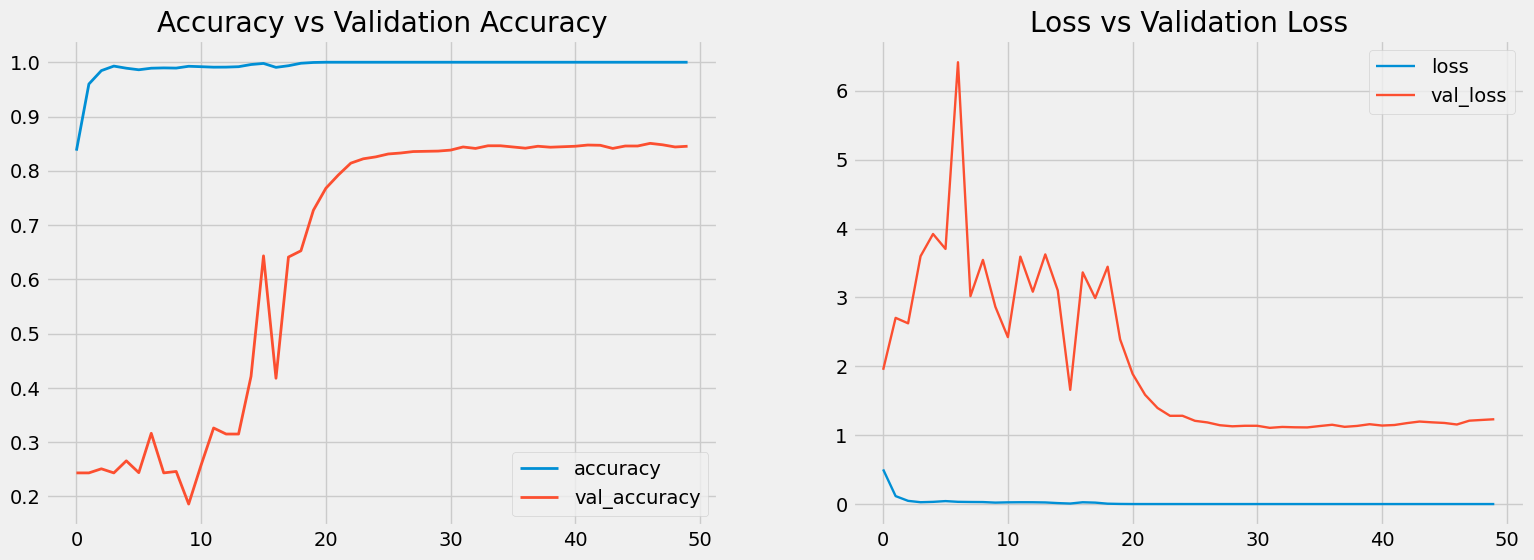

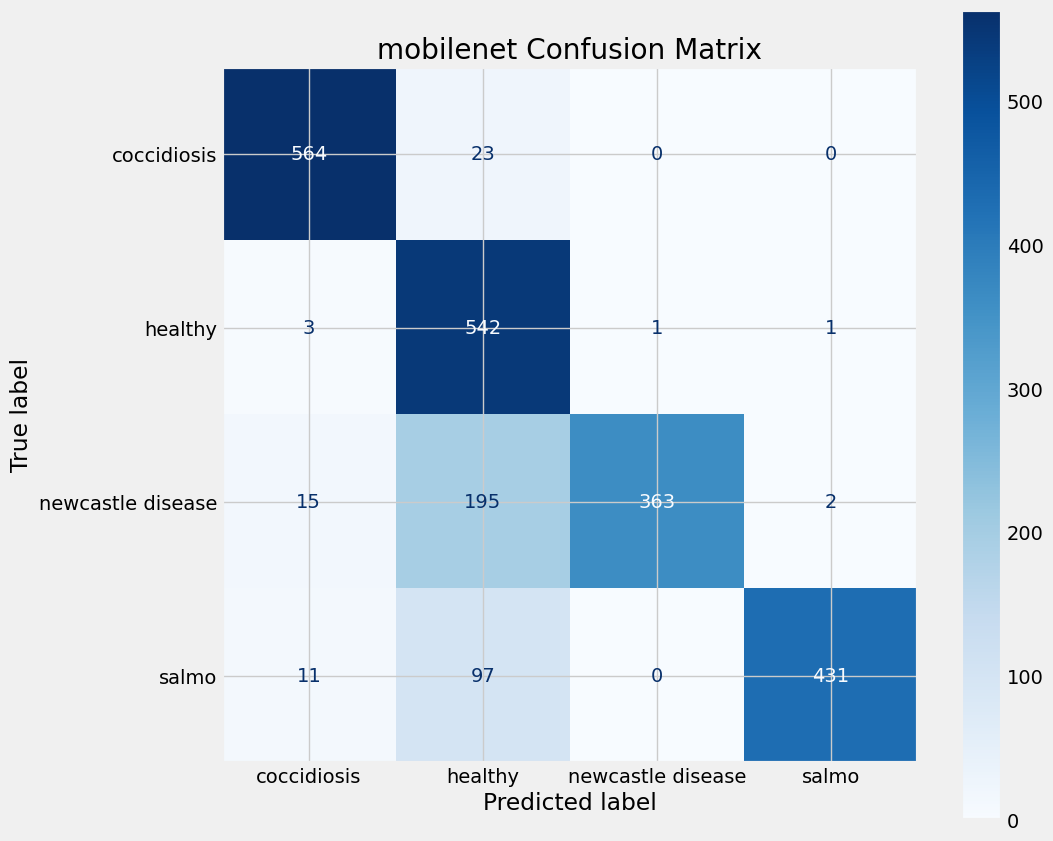

In [ ]:
# 1_output
# include_rescaling true
mn_metric_df_ = fit_model_and_save_logs(mobilenet_model, "mobilenet", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.82251, saving model to mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 - 68s - loss: 0.3391 - accuracy: 0.8941 - val_loss: 0.5979 - val_accuracy: 0.8225 - lr: 1.0000e-04 - 68s/epoch - 242ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.82251 to 0.90125, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0610 - accuracy: 0.9812 - val_loss: 0.3701 - val_accuracy: 0.9012 - lr: 1.0000e-04 - 26s/epoch - 93ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.90125 to 0.94217, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.2428 - val_accuracy: 0.9422 - lr: 1.0000e-04 - 26s/epoch - 93ms/step
Epoch 4/50

Epoch 4: val_accuracy improved from 0.94217 to 0.95018, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0152 - accuracy: 0.9967 - val_loss: 0.1768 - val_accuracy: 0.9502 - lr: 1.0000e-04 - 26s/epoch - 94ms/step
Epoch 5/50

Epoch 5: val_accuracy improved from 0.95018 to 0.95418, saving model to mobilenet_best_model.h5
281/281 - 26s - loss: 0.0161 - accuracy: 0.

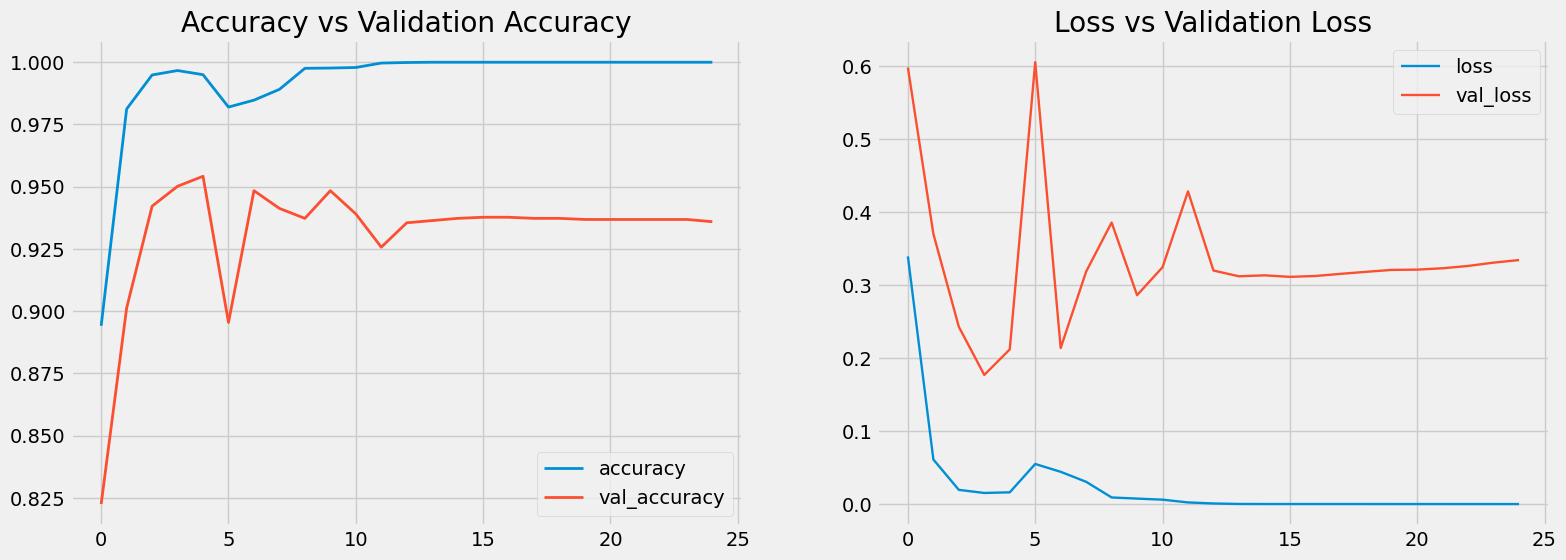

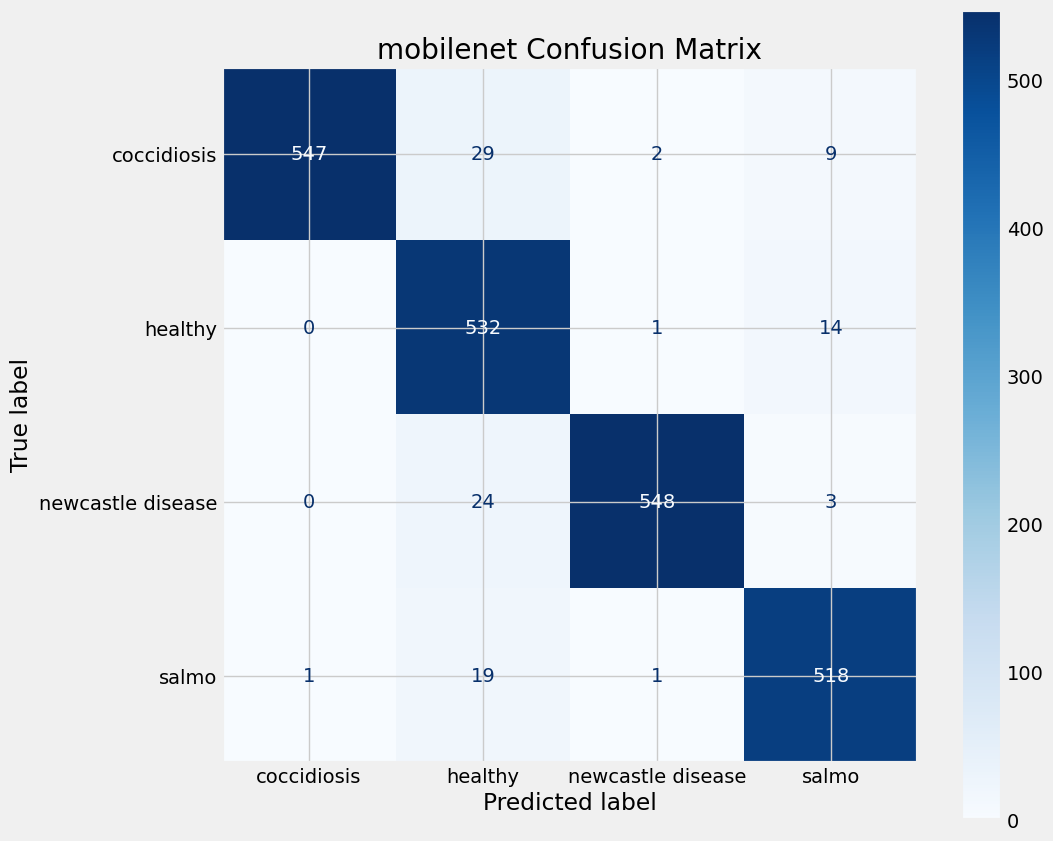

In [ ]:
# 2_output
# include_rescaling false
mn_metric_df_2 = fit_model_and_save_logs(mobilenet_model, "mobilenet", train_batch, valid_batch)

Epoch 1/50

Epoch 1: val_loss improved from inf to 2.11964, saving model to mobilenet_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


253/253 - 64s - loss: 0.3865 - accuracy: 0.8866 - val_loss: 2.1196 - val_accuracy: 0.5978 - lr: 1.0000e-04 - 64s/epoch - 254ms/step
Epoch 2/50

Epoch 2: val_loss improved from 2.11964 to 0.93954, saving model to mobilenet_best_model.h5
253/253 - 23s - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.9395 - val_accuracy: 0.8048 - lr: 1.0000e-04 - 23s/epoch - 90ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.93954 to 0.72364, saving model to mobilenet_best_model.h5
253/253 - 23s - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.7236 - val_accuracy: 0.8315 - lr: 1.0000e-04 - 23s/epoch - 91ms/step
Epoch 4/50

Epoch 4: val_loss improved from 0.72364 to 0.70888, saving model to mobilenet_best_model.h5
253/253 - 23s - loss: 0.0163 - accuracy: 0.9947 - val_loss: 0.7089 - val_accuracy: 0.8305 - lr: 1.0000e-04 - 23s/epoch - 91ms/step
Epoch 5/50

Epoch 5: val_loss improved from 0.70888 to 0.31684, saving model to mobilenet_best_model.h5
253/253 - 23s - loss: 0.0101 - accuracy: 0.9975 - val_loss:

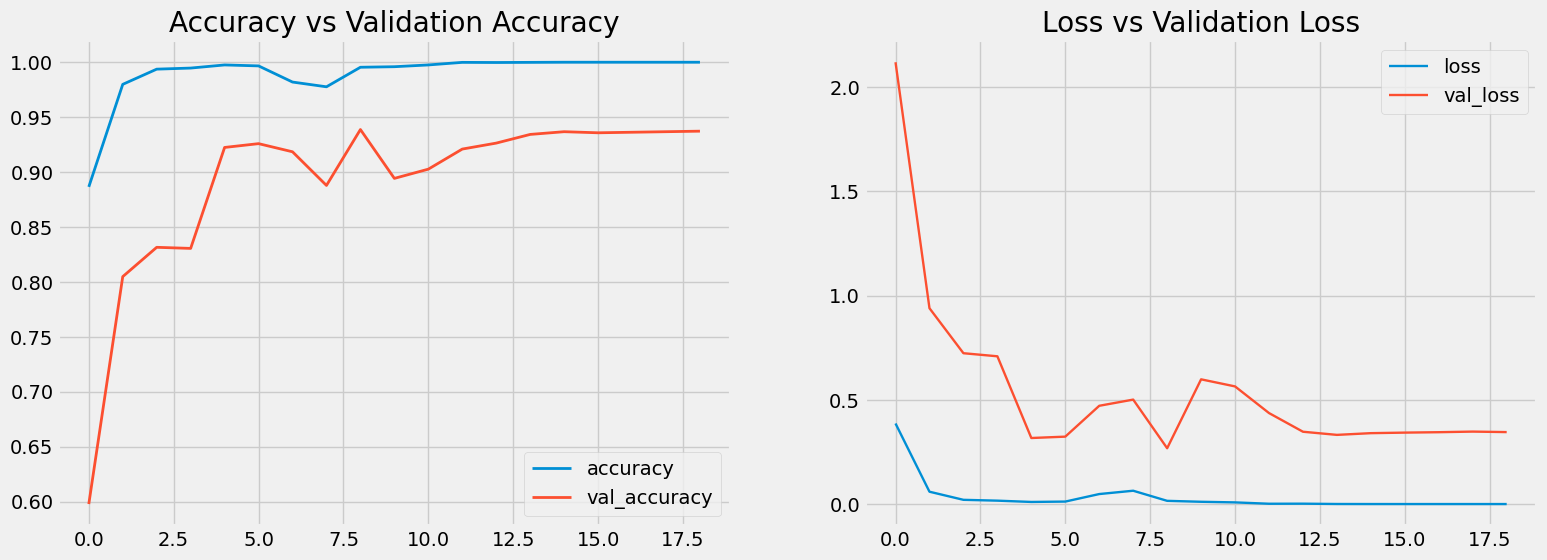

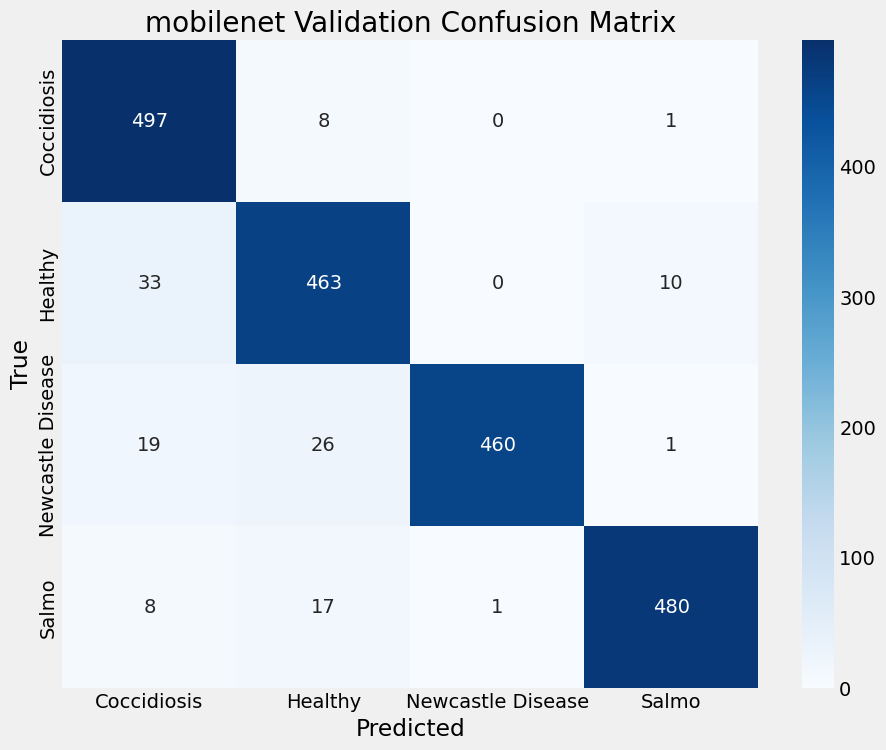

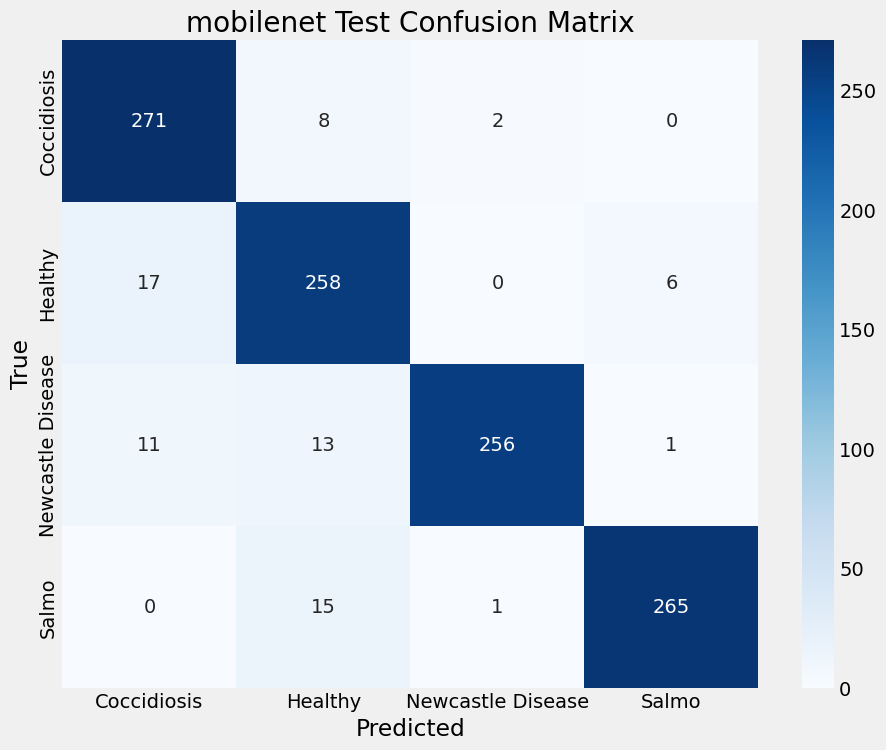

In [ ]:
# 3_output
# include_rescaling false
# monitor val loss - patience ES 10 and RP 5
mn_metric_df_3 = fit_model_and_save_logs(mobilenet_model, "mobilenet", train_batch, val_batch, test_batch)

In [ ]:
mkdir output

In [ ]:
cp -r './output' '/content/drive/MyDrive/Colab Notebooks/pravin_thesis/2_Image_classification/3_MobileNetV3_Large/3_output_split_stable'